### Monte Carlo Option Pricing
https://www.tejwin.com/en/insight/options-pricing-with-monte-carlo-simulation/

In [1105]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import qmc, norm

### We need to simulate the underlying stock path first
$$
dS_t = \mu S_t dt + \sigma S_t dW_t
$$

Consider 
$$
y = ln(S_t) \\

y' = \frac{1}{S_t} ; y'' = -\frac{1}{S_t^2}
$$
Now do Ito's Lemma
$$
 dy = y'dS_t + y''(dS_t)^2 \\
 = \frac{1}{S_t} (\mu S_t dt + \sigma S_t dW_t) - \frac{1}{2} * \frac{1}{S_t^2} (\sigma ^2 S_t ^2 dt) \\
 d(ln(S_t))= (\mu dt + \sigma dW_t) - 0.5 \sigma ^2 dt
$$

You can solve this but why not do this
$$
d(ln(S_t))= ln(S_{t+\Delta t}) - ln(S_{t})
$$

Therefore
$$
ln(S_{t+\Delta t}) = ln(S_{t}) + (\mu - 0.5 \sigma ^2 ) dt + \sigma dW_t
$$

Later to find $S_t$ just do a exponential!

In [1106]:
sigma = 0.1  # vol underlying
r = 0.5  # rfr
q = 0  # dividend
S0 = 100  # init price underlying
T = 1.0  # time in years
N = 100  # timesteps for dt
M = 100  # how many paths?
K = 120

In [1107]:
def generateGBMStock(S0, sigma, r, q, Z):
    # do the randnumber, try with numpy first M * N, i.e. N timesteps for each of the M paths
    dt = T / N
    mudt = (r - q - 0.5 * sigma**2) * dt
    vol_norm = sigma * np.sqrt(dt)
    lnS = np.log(S0)
    deltaZ = vol_norm * Z
    deltaLnS = mudt + deltaZ
    cumsumMatrix = np.cumsum(deltaLnS, axis=1)  # awas salah axis goblok
    cumsumMatrix = np.c_[np.zeros(M), cumsumMatrix]
    lnSMatrix = lnS + cumsumMatrix
    priceMatrix = np.exp(lnSMatrix)
    return priceMatrix

In [1108]:
Z = np.random.normal(size=(M, N))
result_np_random = generateGBMStock(S0, sigma, r, q, Z)

## Let us use Sobol

Faster rate of convergence apparently
https://en.wikipedia.org/wiki/Quasi-Monte_Carlo_method

In [1109]:
sobol = qmc.Sobol(d=N, scramble=True).random(M)
Z_from_sobol = norm.ppf(sobol)

In [1110]:
result_np_qmc = generateGBMStock(S0, sigma, r, q, Z_from_sobol)

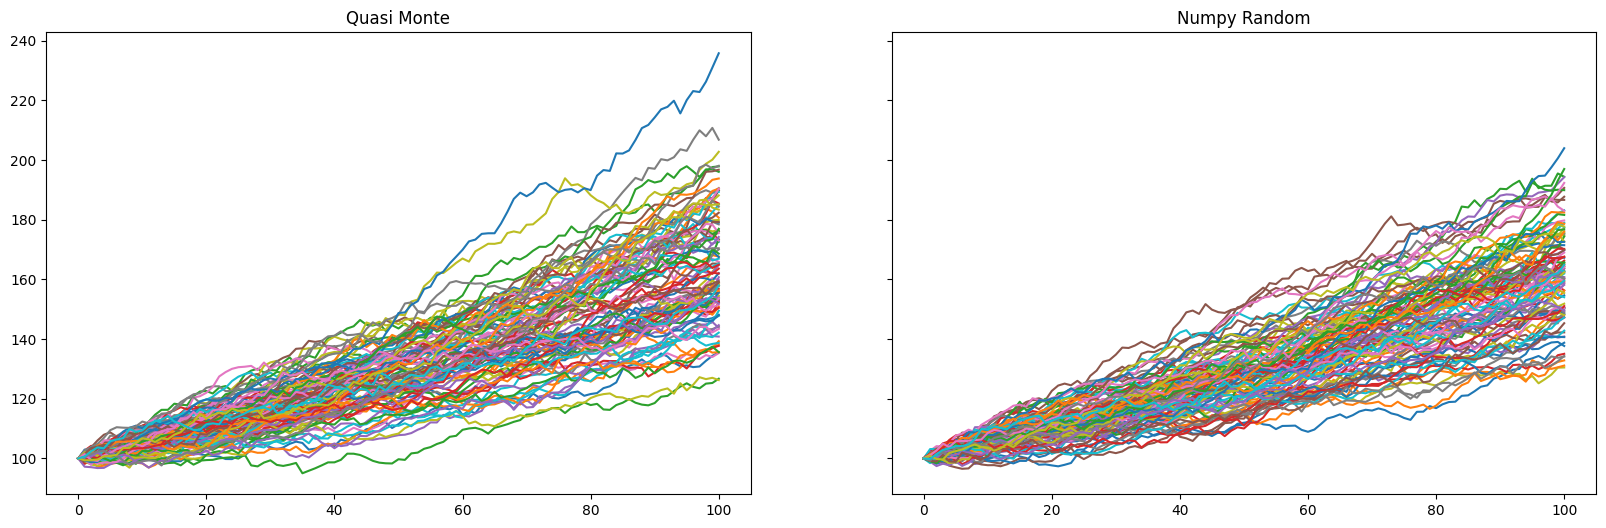

In [1111]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(20, 6))
for i in range(len(result_np_qmc)):
    ax1.set_title("Quasi Monte")
    ax1.plot(result_np_qmc[i])
for i in range(len(result_np_random)):
    ax2.set_title("Numpy Random")
    ax2.plot(result_np_random[i])

In [1112]:
qmc_terminal = result_np_qmc[:, -1]
qmc_call_payoff = np.maximum(qmc_terminal - K, 0)
np_random_terminal = result_np_random[:, -1]
np_random_call_payoff = np.maximum(np_random_terminal - K, 0)

In [1113]:
qmc_call_payoff

array([ 15.52464323,  60.65289757,  77.86179546,  32.26371789,
        34.14420302,  69.80098989,  31.48735209,  58.42719134,
        56.45532659,  64.99577467,  28.11232225,  47.64385323,
         6.7149787 ,  53.39989842,  20.83145362,  69.77386731,
        15.31235626,  86.80853736,  59.91273067,  29.50569146,
        35.64444648,  19.29162693,  56.2300503 ,  65.4176848 ,
        52.61649755,  55.98123956,  33.93474008,  37.77781569,
        68.13611025,  52.60881177,  32.57085365,  30.77471312,
        53.32890534,  36.84564322,  23.73403137,  62.3350959 ,
        45.87093598,  24.23402491,  45.06633991,  46.93949052,
        59.0366973 ,  38.9301997 ,  38.04691592,  32.55267762,
        44.880523  ,  45.26835566,  53.00141458,  50.02057648,
        34.60156026,  69.29737904,  47.48522901,  18.11461432,
        76.03458604,  17.73051449,  54.19858565,  35.56780408,
        39.87000471,  70.57042201,  82.73734477,  18.70695323,
        35.63875514,  36.0996137 ,  48.61298199,  43.59

In [1114]:
qmc_call_price = np.exp(-r * T) * qmc_call_payoff[qmc_call_payoff != 0].mean()

In [1115]:
np_random_call_price = (
    np.exp(-r * T) * np_random_call_payoff[np_random_call_payoff != 0].mean()
)

In [1116]:
def black_scholes_call(S, X, T, r, sigma):
    """
    im not even lying bro this is from gpt
    Calculate the Black-Scholes price for a European call option.

    Parameters:
    S : float : Current stock price
    X : float : Strike price
    T : float : Time to maturity in years
    r : float : Risk-free interest rate
    sigma : float : Volatility of the stock

    Returns:
    float : Call option price
    """
    d1 = (np.log(S / X) + (r - q + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    call_price = (S * norm.cdf(d1)) - (X * np.exp(-r * T) * norm.cdf(d2))

    return call_price

In [1117]:
bs_call_price = black_scholes_call(S0, K, T, r, sigma)

In [1118]:
collect_price = {
    "bs_price": bs_call_price,
    "qmc_price": qmc_call_price,
    "np_random_call_price": np_random_call_price,
}

for x, y in collect_price.items():
    print(f"{x} : {y}")

bs_price : 27.218041067183194
qmc_price : 27.43516971372205
np_random_call_price : 25.83993196106835
